#Preparing the dataset for clustering

In [18]:
import pandas as pd

In [19]:
def wrangle():
  df = pd.read_csv("cleaned_dataset.csv")
  #remove high cardinality features
  df.drop(columns=["name","phone","nationality","city(made-up)"],inplace=True)
  return df

In [20]:
df = wrangle()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        1000 non-null   float64
 1   monthly income             1000 non-null   float64
 2   ns1                        1000 non-null   object 
 3   ns2                        1000 non-null   int64  
 4   ns3                        1000 non-null   object 
 5   sb                         1000 non-null   bool   
 6   gender                     1000 non-null   object 
 7   marital status             1000 non-null   object 
 8   current employment status  1000 non-null   object 
 9   most recent occupation     1000 non-null   object 
 10  dbms                       1000 non-null   object 
 11  visualization tools        1000 non-null   object 
 12  experience(in years)       1000 non-null   int64  
 13  days_since_applying        1000 non-null   float6

we need to make the most recent occupation column into a low cardinality column

In [22]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
occupation_embeddings = model.encode(df['most recent occupation'], show_progress_bar=True)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

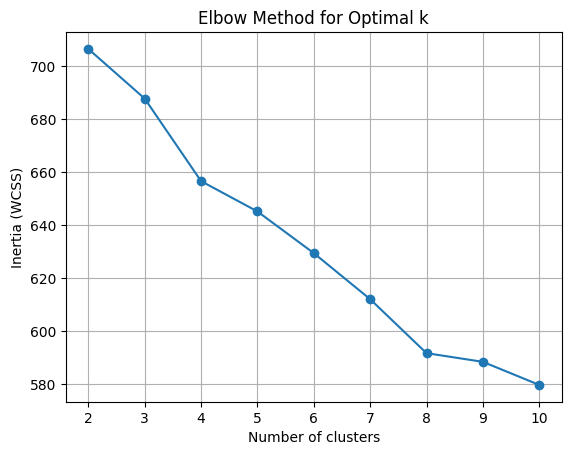

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 11)  # Try 2 to 10 clusters

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(occupation_embeddings)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


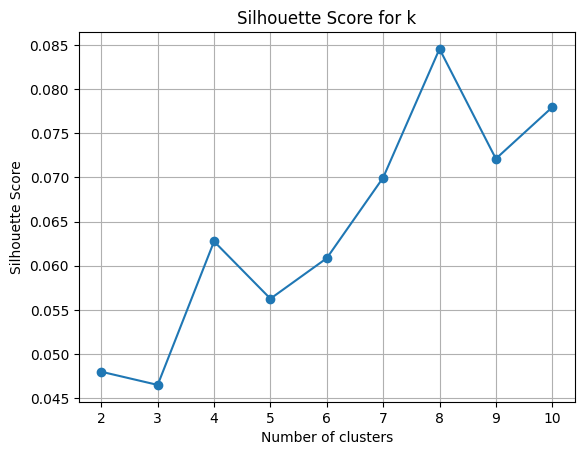

In [24]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(occupation_embeddings)
    sil = silhouette_score(occupation_embeddings, labels)
    sil_scores.append(sil)

plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for k')
plt.grid(True)
plt.show()


In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
occupation_clusters = kmeans.fit_predict(occupation_embeddings)

# Add the cluster labels to your main DataFrame
df['occupation_cluster'] = occupation_clusters


In [26]:
for cluster_num in sorted(df['occupation_cluster'].unique()):
    print(f"\nCluster {cluster_num} Sample Titles:")
    print(df[df['occupation_cluster'] == cluster_num]['most recent occupation'].value_counts().head(10))



Cluster 0 Sample Titles:
most recent occupation
Health promotion specialist                    5
Education officer, community                   5
Secretary/administrator                        5
Government social research officer             4
Charity officer                                4
Armed forces training and education officer    3
Higher education lecturer                      3
Administrator                                  3
Education administrator                        3
Archivist                                      3
Name: count, dtype: int64

Cluster 1 Sample Titles:
most recent occupation
Materials engineer                      5
Computer games developer                5
Games developer                         5
Programmer, applications                5
Ceramics designer                       4
Glass blower/designer                   4
Web designer                            4
Control and instrumentation engineer    4
Engineer, mining                        4
Engineer

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use same order as clusters
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['most recent occupation'])

# For each cluster, show top words
terms = tfidf.get_feature_names_out()
for cluster_num in sorted(df['occupation_cluster'].unique()):
    idxs = df[df['occupation_cluster'] == cluster_num].index
    cluster_mean = X_tfidf[idxs].mean(axis=0)
    top_terms = [terms[i] for i in cluster_mean.A1.argsort()[::-1][:10]]
    print(f"\nCluster {cluster_num} Top Terms: {top_terms}")



Cluster 0 Top Terms: ['officer', 'administrator', 'education', 'community', 'worker', 'arts', 'research', 'teacher', 'government', 'social']

Cluster 1 Top Terms: ['engineer', 'designer', 'developer', 'games', 'systems', 'product', 'materials', 'manufacturing', 'mining', 'applications']

Cluster 2 Top Terms: ['surveyor', 'building', 'minerals', 'residential', 'rural', 'commercial', 'practice', 'control', 'insurance', 'quantity']

Cluster 3 Top Terms: ['scientist', 'clinical', 'animal', 'biomedical', 'research', 'radiographer', 'medical', 'geneticist', 'technologist', 'doctor']

Cluster 4 Top Terms: ['film', 'video', 'broadcasting', 'editor', 'television', 'producer', 'journalist', 'radio', 'copy', 'multimedia']

Cluster 5 Top Terms: ['manager', 'centre', 'officer', 'information', 'farm', 'planner', 'conservator', 'energy', 'transport', 'gallery']

Cluster 6 Top Terms: ['chartered', 'retail', 'accountant', 'buyer', 'gaffer', 'sales', 'management', 'banker', 'dealer', 'lawyer']

Cluster

In [28]:
cluster_labels = {
    0: 'Community & Admin Services',
    1: 'Engineering & Product Dev',
    2: 'Surveying & Real Estate',
    3: 'Science & Research',
    4: 'Media & Creative Arts',
    5: 'Planning & Operations',
    6: 'Business, Finance & Legal',
    7: 'Healthcare & Therapy'
}

df['occupation_category'] = df['occupation_cluster'].map(cluster_labels)


In [29]:
df.drop(columns=["most recent occupation","occupation_cluster"],inplace=True)

In [30]:
df["ns1"] = df["ns1"].astype("object")

numerical_cols = ['age', 'monthly income', 'experience(in years)', 'days_since_applying', 'num_skills']
categorical_cols = ['sb','ns1', 'ns2', 'ns3', 'gender', 'marital status', 'current employment status', 'dbms', 'visualization tools', 'continent', 'occupation_category']


for col in categorical_cols:

      print(df[col].value_counts())
      print("\n")

sb
True     750
False    250
Name: count, dtype: int64


ns1
missing    319
b          258
a          215
c          208
Name: count, dtype: int64


ns2
0    616
1    384
Name: count, dtype: int64


ns3
missing    328
002        175
abc        172
003        166
001        159
Name: count, dtype: int64


gender
missing    390
F          216
M          201
Other      193
Name: count, dtype: int64


marital status
missing    509
single     247
married    244
Name: count, dtype: int64


current employment status
missing       385
freelancer    231
employed      194
unemployed    190
Name: count, dtype: int64


dbms
missing    407
SQL        206
Excel      202
Python     185
Name: count, dtype: int64


visualization tools
missing    412
R          203
PowerBI    195
Tableau    190
Name: count, dtype: int64


continent
Asia             214
Africa           199
Europe           184
North America    172
Oceania           94
Unknown           74
South America     58
Antarctica         5
Name: 

In [31]:
df["sb"] = df["sb"].astype(int)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# columns that have high cluster value (from our initial EDA)
numeric_cols = [ 'monthly income',"ns2"]
categorical_cols = ['ns1', 'ns3', 'gender', 'marital status', 'current employment status',
                    'dbms', 'visualization tools', 'continent', 'occupation_category']

# Pipeline for categorical features: OneHotEncoder
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

# Pipeline for numeric features: StandardScaler
num_pipeline = StandardScaler()

# Compose preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])



In [33]:
X = preprocessor.fit_transform(df)

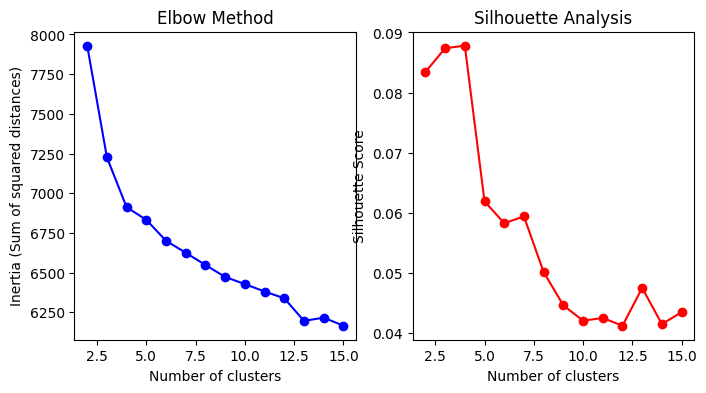

In [34]:
#Elbow method
inertia = []
sil_scores = []
K = range(2, 16)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting Elbow
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method')

# Plotting Silhouette Score
plt.subplot(1,2,2)
plt.plot(K, sil_scores, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.show()

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Create full pipeline including preprocessing + clustering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

# Fit the pipeline to your data
pipeline.fit(df)

# Get cluster labels for each row
labels = pipeline.named_steps['kmeans'].labels_

# You can add these labels back to your original DataFrame if you want
df['cluster'] = labels


In [36]:
sil_score = silhouette_score(pipeline[:-1].transform(df), labels)
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.088


In [37]:
df["cluster"].value_counts()

,count
cluster,
2,309
3,307
0,193
1,191


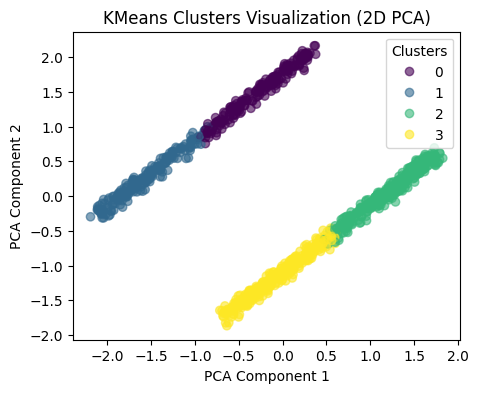

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Transform your data with the preprocessor (same one used in the pipeline)
X_processed = preprocessor.transform(df)

# Step 2: Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)

# Step 3: Plot clusters in 2D space
plt.figure(figsize=(5,4))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters Visualization (2D PCA)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [ ]:
df.to_csv("clustered_dataset.csv",index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        1000 non-null   float64
 1   monthly income             1000 non-null   float64
 2   ns1                        1000 non-null   object 
 3   ns2                        1000 non-null   int64  
 4   ns3                        1000 non-null   object 
 5   sb                         1000 non-null   int64  
 6   gender                     1000 non-null   object 
 7   marital status             1000 non-null   object 
 8   current employment status  1000 non-null   object 
 9   dbms                       1000 non-null   object 
 10  visualization tools        1000 non-null   object 
 11  experience(in years)       1000 non-null   int64  
 12  days_since_applying        1000 non-null   float64
 13  continent                  1000 non-null   object